In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

# Custom Libs
import sys, os
sys.path.insert(0, os.path.dirname(os.path.abspath('../')))
from ridgepy.libridgewrapper.config import MAIN_CONFIG
from ridgepy.libridgewrapper.kalman_filter_mode import KalmanFilterMode
from ridgepy.libridgewrapper.kalman_filter_network import KalmanFilterNetwork

# Input
A practical example with an audio input.

In [3]:
frequency_sample, observation = sp.io.wavfile.read("example_audio_file.wav")
data_count = len(observation)
time_delta = 1./frequency_sample

time = np.arange(0.0, data_count * time_delta, time_delta)

print(f"The sample frequency is {frequency_sample} Hz.")
print(f"The number of samples is {data_count}.")

data_df = pd.DataFrame({
    'time': time,
    'observation': observation
})

data_df.head()

The sample frequency is 16000 Hz.
The number of samples is 46797.


,time,observation
0,0.000000,1
1,0.000063,-1
2,0.000125,2
3,0.000188,0
4,0.000250,0


<Axes: xlabel='time'>

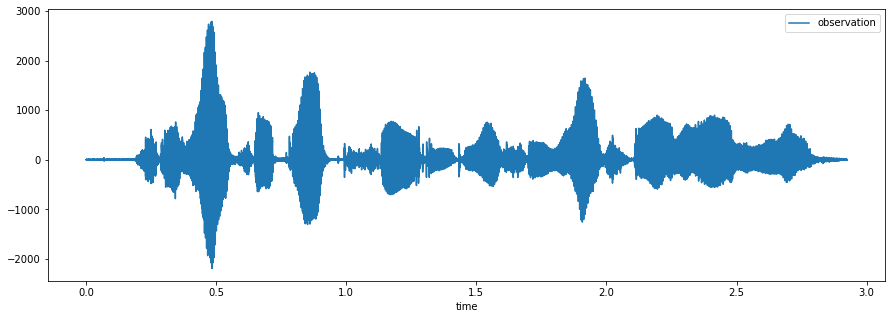

In [4]:
data_df.plot(x='time', y='observation', figsize=(15,5))

# Kalman Filter Network
The network is a collection of modes.

Each mode has a frequency, a set of coefficients, and a set of covariance
matrices.

The number of frequencies and their values are the key parameters in the
network. In a Discrete Fourier Transform, the frequencies are determined from a
linear spacing on teh region [0, Nf/2]. Other strategies include Mel frequency
spacing, or whatever else.

In [5]:
# Simple example with frequencies at 50, 100, ..., 500 Hz.
frequencies = np.arange(31.25, 8000, 31.25)
modes = []
for frequency in frequencies:
    # The signal noise covariance is a 2x2 matrix.
    signal_noise_covariance = np.zeros((2,2))
    signal_noise_covariance[0][0] = 0.0001
    signal_noise_covariance[1][1] = 0.0001

    signal_error_covariance = np.zeros((2,2))
    signal_error_covariance[0][0] = 1.0
    signal_error_covariance[1][1] = 1.0

    # The observation noise covariance is a scalar.
    observation_noise_covariance = 10.0

    # The coefficients are a 2 X 1 matrix.
    sin_coefficient = 0.0
    cos_coefficient = 0.0

    mode = KalmanFilterMode(
        frequency,
        sin_coefficient,
        cos_coefficient,
        signal_error_covariance,
        signal_noise_covariance,
        observation_noise_covariance
    )
    modes.append(mode)

In [6]:
frequency_sample = 16000.
print(len(modes))
kf_network = KalmanFilterNetwork(modes)

255


# Network Updates
In the code below, the network update is called recursively on the next
observation.  In this example, the sampling frequency of the observations is
constant, but that does not need to be true.

In [7]:
time_step_data = []

for ndx in range(0, len(data_df)):

    ## Update the prior
    kf_network.prior_update(frequency_sample)

    ## Update the posterior
    kf_network.posterior_update(data_df.at[ndx, 'observation'])

    ## Change the logging below to use a dictionary
    # current_parameters = kf_network.current_parameters()

    # time_step_data.append(current_parameters)

# results_df = pd.DataFrame(time_step_data)

In [8]:
results_df.head()

NameError: name 'results_df' is not defined

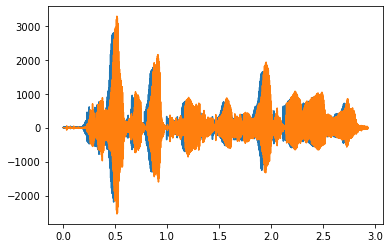

In [ ]:
plt.plot(data_df['time'], data_df['observation'], label='observation')
plt.plot(data_df['time'], results_df['prediction'], label='prediction')


# Results
The typical solution would be to use a spectrogram. That is shown in the first
image below, along with the results from the Kalman Filter Network

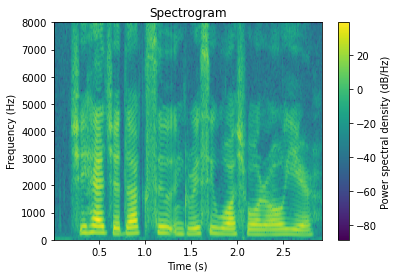

In [ ]:
fs = 1./(data_df.at[1, 'time'] - data_df.at[0, 'time'])
plt.specgram(data_df['observation'], NFFT=256, Fs=fs, cmap='viridis')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram')
plt.colorbar(label='Power spectral density (dB/Hz)')
plt.show()

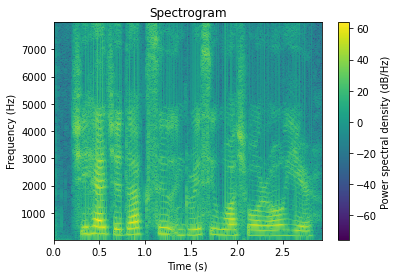

In [ ]:

magnitudes = np.array(results_df['magnitudes'].apply(np.array).tolist())
magnitudes_db = np.log10(magnitudes) * 20.0

frequencies = np.array(results_df['frequencies'].apply(np.array).tolist())
times = data_df['time']
plt.pcolormesh(times, frequencies.T, magnitudes_db.T, cmap='viridis')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram')
plt.colorbar(label='Power spectral density (dB/Hz)')
plt.show()